### Import Libraries

In [60]:
# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


### Load the Datasets

In [61]:
# Load fold-change results
fold_change_data = pd.read_csv('../results/fold_change_results.csv')
logging.info(f"Fold-change data successfully loaded. Shape: {fold_change_data.shape}")
print(fold_change_data.head())

# Load processed data containing miRNA expression values and target variables
processed_data = pd.read_csv('../processed_data/miRNA_stage_subtype.csv')
logging.info(f"Processed data successfully loaded. Shape: {processed_data.shape}")
print(processed_data.head())

2025-01-24 17:41:35,530 - INFO - Fold-change data successfully loaded. Shape: (1882, 4)


       Unnamed: 0  log2_fold_change  absolute_fold_change   regulation
0    hsa-mir-518f         15.479993             15.479993  upregulated
1         subtype         13.808021             13.808021  upregulated
2    hsa-mir-520e         13.290780             13.290780  upregulated
3    hsa-mir-520d         13.166629             13.166629  upregulated
4  hsa-mir-1283-2         12.642423             12.642423  upregulated


2025-01-24 17:41:35,776 - INFO - Processed data successfully loaded. Shape: (1091, 1883)


   hsa-let-7a-1  hsa-let-7a-2  hsa-let-7a-3    hsa-let-7b   hsa-let-7c  \
0   7314.747386   7391.483138   7334.393081  10994.201497   471.496698   
1   9518.042994   9460.443528   9574.874468  17578.281899   785.810318   
2   4479.976340   4387.407628   4447.955716  12394.310110   404.624244   
3  21277.962603  21166.590502  21255.800397  15161.474118  6684.570363   
4   8002.355461   8013.396682   8033.638922  19358.942067  1276.411235   

   hsa-let-7d   hsa-let-7e  hsa-let-7f-1  hsa-let-7f-2   hsa-let-7g  ...  \
0  318.193106  1156.241547   3272.099771   3363.611772   442.783758  ...   
1  358.652676   771.986446   3871.452122   3917.224498   487.829079  ...   
2  855.241747   246.267705   1353.016896   1415.311564   416.850300  ...   
3  503.278464  2185.922959  15012.229891  14987.262342  1107.549261  ...   
4  765.754731   593.005616   2630.801098   2649.433160   367.580673  ...   

   hsa-mir-943  hsa-mir-944  hsa-mir-95  hsa-mir-9500  hsa-mir-96  hsa-mir-98  \
0          0.0   

### Prepare the Data

In [67]:
# Select top miRNA features based on fold-change
# top_features = fold_change_data.nlargest(50, 'log2_fold_change')['Unnamed: 0']  # Select top 50 miRNAs
top_features = fold_change_data['Unnamed: 0']  # Select all miRNAs

# Filter out non-miRNA entries (e.g., subtype, stage)
top_features = top_features[top_features.str.startswith('hsa-')]  # Keep only miRNA names

# Filter the processed data for selected miRNAs
expression_values = processed_data[top_features]  # Use top features (miRNA names) as column selectors

# Use 'stage' or 'subtype' as the target variable
y = processed_data['stage']  # Target variable (e.g., stage or subtype)

# Check for missing values in features or labels
if expression_values.isnull().values.any() or y.isnull().values.any():
    logging.warning("Missing values detected in features or labels.")
    print(f"Missing values in features:\n{expression_values.isnull().sum()}")
    print(f"Missing values in labels:\n{y.isnull().sum()}")
    # Handle missing values (e.g., drop rows or impute values)
    expression_values = expression_values.dropna()
    y = y.dropna()

# Check the target distribution
print("Target distribution:")
print(y.value_counts())

# Validate shapes and log
logging.info(f"Features shape: {expression_values.shape}")
logging.info(f"Labels shape: {y.shape}")

# Preview the data
print("\nFeature sample:")
print(expression_values.head())

print("\nLabel sample:")
print(y[:5])  # Show first 5 samples

2025-01-24 17:44:59,418 - INFO - Features shape: (1091, 1881)
2025-01-24 17:44:59,419 - INFO - Labels shape: (1091,)


Target distribution:
stage
1    566
2    308
3    175
4     31
0     11
Name: count, dtype: int64

Feature sample:
   hsa-mir-518f  hsa-mir-520e  hsa-mir-520d  hsa-mir-1283-2  hsa-mir-520h  \
0      0.000000           0.0      0.000000             0.0           0.0   
1      0.307197           0.0      0.000000             0.0           0.0   
2      0.000000           0.0      0.582193             0.0           0.0   
3      0.000000           0.0      0.000000             0.0           0.0   
4      0.000000           0.0      0.000000             0.0           0.0   

   hsa-mir-523  hsa-mir-519d  hsa-mir-515-2  hsa-mir-524  hsa-mir-521-2  ...  \
0     0.000000      0.000000       0.000000     0.000000            0.0  ...   
1     0.000000      0.153599       0.153599     0.000000            0.0  ...   
2     0.000000      0.000000       0.000000     0.000000            0.0  ...   
3     0.000000      0.000000       0.000000     0.280534            0.0  ...   
4     0.230025      0.

#### SMOTE for balancing the dataset

In [68]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(expression_values, y)

# Verify the new target distribution after SMOTE
print("New target distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Log the new split sizes and class distributions
logging.info(f"Training set size after SMOTE: {X_train.shape}")
logging.info(f"Testing set size after SMOTE: {X_test.shape}")
logging.info(f"Target distribution in training set: {pd.Series(y_train).value_counts().to_dict()}")
logging.info(f"Target distribution in testing set: {pd.Series(y_test).value_counts().to_dict()}")


2025-01-24 17:45:00,544 - INFO - Training set size after SMOTE: (2264, 1881)
2025-01-24 17:45:00,544 - INFO - Testing set size after SMOTE: (566, 1881)
2025-01-24 17:45:00,545 - INFO - Target distribution in training set: {1: 453, 0: 453, 2: 453, 4: 453, 3: 452}
2025-01-24 17:45:00,546 - INFO - Target distribution in testing set: {3: 114, 0: 113, 2: 113, 4: 113, 1: 113}


New target distribution after SMOTE:
stage
1    566
3    566
2    566
4    566
0    566
Name: count, dtype: int64


### Train-Test Split

In [69]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Scale training set
X_test = scaler.transform(X_test)       # Scale testing set

# Log scaled feature details
logging.info(f"Training set size after scaling: {X_train.shape}")
logging.info(f"Testing set size after scaling: {X_test.shape}")
logging.info(f"Feature scaling applied using StandardScaler.")

2025-01-24 17:45:01,260 - INFO - Training set size after scaling: (2264, 1881)
2025-01-24 17:45:01,261 - INFO - Testing set size after scaling: (566, 1881)
2025-01-24 17:45:01,261 - INFO - Feature scaling applied using StandardScaler.


### Train the SVM Classifier

In [70]:
from sklearn.svm import SVC

# Initialize SVM with RBF kernel and balanced class weights
svm_classifier = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Train the classifier
logging.info("Training the SVM classifier with RBF kernel...")
svm_classifier.fit(X_train, y_train)
logging.info("SVM training completed.")

# Make predictions
logging.info("Making predictions on the test set...")
y_pred = svm_classifier.predict(X_test)
logging.info("Predictions completed.")

# Log model parameters
logging.info(f"Model parameters: Kernel: {svm_classifier.kernel}, Class Weight: {svm_classifier.class_weight}")

2025-01-24 17:45:02,067 - INFO - Training the SVM classifier with RBF kernel...
2025-01-24 17:45:05,642 - INFO - SVM training completed.
2025-01-24 17:45:05,643 - INFO - Making predictions on the test set...
2025-01-24 17:45:06,828 - INFO - Predictions completed.
2025-01-24 17:45:06,828 - INFO - Model parameters: Kernel: rbf, Class Weight: balanced


### Evaluate the Model

2025-01-24 17:45:06,838 - INFO - Model Accuracy: 0.87
2025-01-24 17:45:06,847 - INFO - Confusion Matrix:


Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       0.74      0.65      0.69       113
           2       0.74      0.82      0.78       113
           3       0.90      0.90      0.90       114
           4       1.00      1.00      1.00       113

    accuracy                           0.87       566
   macro avg       0.87      0.87      0.87       566
weighted avg       0.87      0.87      0.87       566

[[113   0   0   0   0]
 [  0  73  30  10   0]
 [  0  18  93   2   0]
 [  0   8   3 103   0]
 [  0   0   0   0 113]]


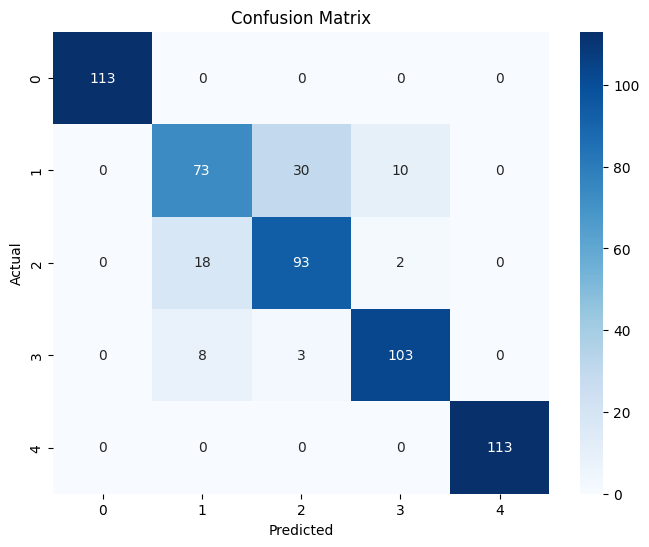

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Map numerical labels back to class names if LabelEncoder was used
if 'le' in locals() and hasattr(le, 'classes_'):  # Check if LabelEncoder exists
    target_names = le.classes_
else:
    target_names = [str(cls) for cls in sorted(set(y_test))]  # Fallback to numeric labels as strings

# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
logging.info(f"Model Accuracy: {accuracy:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Generate and print detailed classification report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
logging.info("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Save Results

In [72]:
import os
import json

# Save predictions and actual labels
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Add confidence scores if available
if hasattr(svm_classifier, 'decision_function'):
    # Get confidence scores for all classes
    confidence_scores = svm_classifier.decision_function(X_test)
    
    # Save the confidence score for the predicted class
    results['Confidence'] = [scores[pred] for scores, pred in zip(confidence_scores, y_pred)]

# Save results to CSV
output_path = '../results/svm_baseline_results.csv'
try:
    results.to_csv(output_path, index=False)
    logging.info(f"Results saved successfully to {output_path}")
    print(f"Results saved to {output_path}")
except Exception as e:
    logging.error(f"Failed to save results: {e}")
    print(f"Error: {e}")

# Optional: Save metadata for tracking experiments
metadata = {
    'Training Set Size': X_train.shape[0],
    'Test Set Size': X_test.shape[0],
    'Kernel': svm_classifier.kernel,
    'Class Weights': svm_classifier.class_weight,
    'Accuracy': accuracy_score(y_test, y_pred)  # Add overall accuracy for completeness
}
metadata_path = '../results/experiment_metadata.json'
try:
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
        logging.info("Experiment metadata saved successfully.")
        print(f"Metadata saved to {metadata_path}")
except Exception as e:
    logging.error(f"Failed to save metadata: {e}")
    print(f"Error: {e}")

2025-01-24 17:46:46,958 - INFO - Results saved successfully to ../results/svm_baseline_results.csv
2025-01-24 17:46:46,960 - INFO - Experiment metadata saved successfully.


Results saved to ../results/svm_baseline_results.csv
Metadata saved to ../results/experiment_metadata.json
